In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import sklearn
import random as rn
from keras.layers import Dense
from keras import Input
from keras.engine import Model
from keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D

https://m.blog.naver.com/PostView.nhn?blogId=sexyit_2019&logNo=221603292906&proxyReferer=https:%2F%2Fwww.google.com%2F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 오디오 데이터
DATA_DIR_TRAIN = '/content/drive/My Drive/졸프/0726Data/train2/'
DATA_DIR_TEST = '/content/drive/My Drive/졸프/0726Data/test2/'

In [ ]:
wav, sr = librosa.load(DATA_DIR_TRAIN + '음100.wav', sr=16000)
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

sr: 16000
wav shape: (3874,)
length: 0.242125 secs


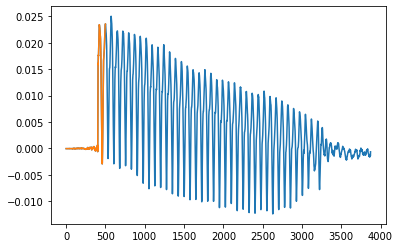

In [ ]:
# raw wave
print(plt.plot(wav))
print(plt.plot(wav[0:500]))

In [ ]:
train_X = []
train_spectrograms = []
train_mel_spectograms = []
train_mfccs = []
train_y = []

test_X = []
test_spectrograms = []
test_mel_spectograms = []
test_mfccs = []
test_y = []

pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i-a.shape[0])))
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))

# STFT 한 것, CNN 분석하기 위해 Spectogram으로 만든 것, MF한 것, mel0spectogram 한 것

In [ ]:
from unicodedata import normalize

In [ ]:
dataset0 = [] # 추임새
dataset1 = [] # 비추임새

test_dataset = []
train_dataset = []

frame_length = 0.025
frame_stride = 0.001

In [ ]:
input_nfft = int(round(sr*frame_length))
input_stride = int(round(sr*frame_stride))
print(input_nfft,input_stride)

400 16


In [ ]:
#train data set
for filename in os.listdir(DATA_DIR_TRAIN):
  filename = normalize('NFC', filename) # 'ㅇㅡㅁ.wav' -> '음.wav'
  try:
    if '.wav' not in filename:
      continue
      
    wav, sr = librosa.load(DATA_DIR_TRAIN + filename, sr=16000)
  
    mfcc = librosa.feature.mfcc(wav)
    #mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    padded_mfcc = pad2d(mfcc, 40)

    # 추임새/비추임새 구분하여 dataset에 추가
    if filename[0] == '외':
      train_dataset.append((padded_mfcc, 1))
    else:
      train_dataset.append((padded_mfcc, 0))
  except Exception as e:
    print(filename, e)
    raise

# test data set
for filename in os.listdir(DATA_DIR_TEST):
  filename = normalize('NFC', filename)
  try:
    if '.wav' not in filename:
      continue
      
    wav, sr = librosa.load(DATA_DIR_TEST + filename, sr=16000)

    input_nfft = int(round(sr*frame_length))
    input_stride = int(round(sr*frame_stride))
  
    mfcc = librosa.feature.mfcc(wav)
    #mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    padded_mfcc = pad2d(mfcc, 40)

    # 추임새/비추임새 구분하여 dataset에 추가
    if filename[0] == '외':
      test_dataset.append((padded_mfcc, 1))
    else:
      test_dataset.append((padded_mfcc, 0))
  except Exception as e:
    print(filename, e)
    raise

# 데이터셋을 셔플
import random
random.shuffle(test_dataset)
random.shuffle(train_dataset)

train_mfccs = [a for (a,b) in train_dataset]
train_y = [b for (a,b) in train_dataset]

test_mfccs = [a for (a,b) in test_dataset]
test_y = [b for (a,b) in test_dataset]

train_mfccs = np.array(train_mfccs)
train_y = to_categorical(np.array(train_y))

test_mfccs = np.array(test_mfccs)
test_y = to_categorical(np.array(test_y))

print('train_mfccs:', train_mfccs.shape)
print('train_y:', train_y.shape)

print('test_mfccs:', test_mfccs.shape)
print('test_y:', test_y.shape)

train_mfccs: (3798, 20, 40)
train_y: (3798, 2)
test_mfccs: (346, 20, 40)
test_y: (346, 2)


In [ ]:
# MFCC feature로 학습

In [ ]:
train_X_ex = np.expand_dims(train_mfccs, -1)
test_X_ex = np.expand_dims(test_mfccs, -1)
print('train X shape:', train_X_ex.shape)
print('test X shape:', test_X_ex.shape)

train X shape: (3798, 20, 40, 1)
test X shape: (346, 20, 40, 1)


In [ ]:
ip = Input(shape=train_X_ex[0].shape)

m = Conv2D(32, kernel_size=(4,4), activation='relu')(ip)
#m = BatchNormalization()(m)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Conv2D(32*2, kernel_size=(4,4), activation='relu')(ip)
#m = BatchNormalization()(m)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Conv2D(32*3, kernel_size=(4,4), activation='relu')(ip)
#m = BatchNormalization()(m)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Flatten()(m)

m = Dense(32)(m)
#m = BatchNormalization()(m)
m = Activation("relu")(m)

op = Dense(2, activation='softmax')(m)

model = Model(ip, op)

model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 20, 40, 1)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 17, 37, 96)        1632      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 9, 96)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3456)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                110624    
_________________________________________________________________
activation_8 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X_ex,
                    train_y,
                    epochs=100,
                    batch_size=32,
                    verbose=1,
                    validation_data=(test_X_ex, test_y))

Epoch 1/100
119/119 [==============================] - 1s 4ms/step - loss: 0.8387 - accuracy: 0.8605 - val_loss: 0.2241 - val_accuracy: 0.9220
Epoch 2/100
119/119 [==============================] - 0s 3ms/step - loss: 0.1794 - accuracy: 0.9284 - val_loss: 0.2084 - val_accuracy: 0.9220
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 0.1320 - accuracy: 0.9492 - val_loss: 0.2048 - val_accuracy: 0.9364
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 0.1192 - accuracy: 0.9539 - val_loss: 0.1487 - val_accuracy: 0.9451
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 0.1301 - accuracy: 0.9473 - val_loss: 0.6737 - val_accuracy: 0.8468
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 0.1092 - accuracy: 0.9571 - val_loss: 0.1289 - val_accuracy: 0.9595
Epoch 7/100
119/119 [==============================] - 0s 3ms/step - loss: 0.0956 - accuracy: 0.9616 - val_loss: 0.1445 - val_accuracy: 0.9538

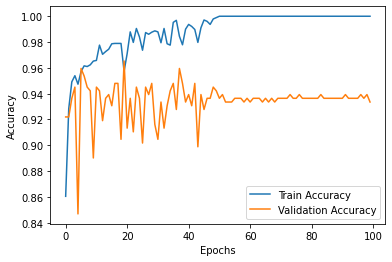

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# model test

In [ ]:
wav, sr = librosa.load(DATA_DIR_TRAIN + '외100.wav', sr=16000)
input_nfft = int(round(sr*frame_length))
input_stride = int(round(sr*frame_stride))
mfcc = librosa.feature.mfcc(wav,n_mfcc=100, n_mels=100, n_fft=input_nfft, hop_length=input_stride)
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
padded_mfcc = pad2d(mfcc, 40)

In [ ]:
padded_mfcc = np.expand_dims(padded_mfcc, 0)
padded_mfcc = np.expand_dims(padded_mfcc, -1)

In [ ]:
model.predict(padded_mfcc)

array([[3.9280386e-04, 9.9960726e-01]], dtype=float32)

# model save

In [ ]:
model.save('/content/drive/My Drive/졸프/0726Data/filler_determine_model_by_train2_1205.h5')


In [ ]:
import pickle

In [ ]:
model_file_path = '/content/drive/My Drive/졸프/0726Data/filler_determine_model_33mfcc_modified.plk'
pickle.dump(model, open(model_file_path, 'wb'))

TypeError: ignored

In [ ]:
# 샘플 오디오 데이터
DATA_DIR = '/content/drive/My Drive/졸프/'

wav, sr = librosa.load(DATA_DIR + 'sample.m4a', sr=None)
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

sr: 44100
wav shape: (1651712,)
length: 37.45378684807256 secs


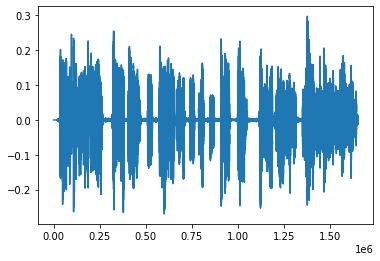

In [ ]:
# raw wave
print(plt.plot(wav))
print(plt.plot(wav[0:500]))

In [ ]:
# wav, sr = librosa.load(DATA_DIR + 'sample.m4a')
padded_x = pad1d(wav, 30000)
mfcc = librosa.feature.mfcc(wav, n_mfcc=33)
padded_mfcc = pad2d(mfcc, 40)
padded_mfcc = np.expand_dims(padded_mfcc, 0)

In [ ]:
model.predict(padded_mfcc)

array([[1.0000000e+00, 2.9907361e-12]], dtype=float32)